<a href="https://colab.research.google.com/github/Arjun-RY/E-commerce_customer_Segmentation/blob/main/E_commerce_customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Package import and installation  

In [ ]:
!pip install pattern
!pip install plotly

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from pattern.text.en import singularize
from functools import reduce
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans
from os import path
from wordcloud import WordCloud
from collections import Counter

lemmatizer = WordNetLemmatizer()

In [242]:
import warnings
warnings.filterwarnings("ignore")

##Data Cleaning

In [243]:
df = pd.read_csv('project_data.csv',encoding="ISO-8859-1")
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### CustomerID
    Since, it is the target column and it has more null values, I started cleaning from this column

In [245]:
df.CustomerID.dtype

dtype('float64')

In [246]:
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [247]:
406829/541909

0.750733056657114

Out of 541909 transactions ,there are only 406829(75%) transactions with CustomerID. There are 4372 unique customers who made those 406829 transactions.

In [248]:
no_of_null=541909-406829
print('No of Transaction without CustomerID : ',no_of_null)

No of Transaction without CustomerID :  135080


####Impute missing values in CustomerID columns
Reverse searching missing values of CustomerID using InvoiceNo column, since each InvoiceNo is connected to a single Customer

In [249]:
df1=df[df["CustomerID"].isnull()]
print(df1.shape)
df1.head()

(135080, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [250]:
invoice=df1.InvoiceNo.unique()
print('No of unique InvoiceNo without CustomerID : ',len(invoice))
invoice

No of unique InvoiceNo without CustomerID :  3710


array(['536414', '536544', '536545', ..., '581492', '581497', '581498'],
      dtype=object)

In [251]:
count=0
for x in df['InvoiceNo']:
  if x in invoice:
    count+=1
print('Total no of transactions with InvoiceNo without CustomerID(with InvoiceNo in invoice) : ',count)

Total no of transactions with InvoiceNo without CustomerID(with InvoiceNo in invoice) :  135080


No of Transactions without CustomerID and no of Transactions without CustomerID(after reverse searching) are same(135080). Hence, null values of CustomerID cannot be imputed. Null values have to be dropped.

In [252]:
df = df[df['CustomerID'].notna()]
df.shape

(406829, 8)

In [253]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


CustomerID should be in 'object' datatype instead of 'float64'. Since, each  CustomerID is unique to a single customer.

In [254]:
df.CustomerID = df.CustomerID.astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      406829 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 27.9+ MB


###InvoiceNo

In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      406829 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 27.9+ MB


In [256]:
df.nunique()

InvoiceNo      22190
StockCode       3684
Description     3896
Quantity         436
InvoiceDate    20460
UnitPrice        620
CustomerID      4372
Country           37
dtype: int64

In [257]:
df.InvoiceNo.dtype

dtype('O')

Checking for improper InvoiceNo in the data

In [258]:
in1=set()
in2=set()
in3=set()
for x in df['InvoiceNo']:
  if  x.isdigit() == False and x[0].isalpha():
    in1.add(x)
  elif x.isdigit() == True :
    in2.add(x)
  else:
    in3.add(x)
print(len(in1))
print(len(in2))
print(len(in3))

3654
18536
0


In [259]:
print(df[df['InvoiceNo']=='C563220'])

       InvoiceNo StockCode                          Description  Quantity  \
300943   C563220     23243  SET OF TEA COFFEE SUGAR TINS PANTRY        -2   
300944   C563220     22469                HEART OF WICKER SMALL        -6   
300945   C563220     21289     LARGE STRIPES CHOCOLATE GIFT BAG        -4   

            InvoiceDate  UnitPrice CustomerID         Country  
300943  8/14/2011 14:22       4.95    16150.0  United Kingdom  
300944  8/14/2011 14:22       1.65    16150.0  United Kingdom  
300945  8/14/2011 14:22       1.25    16150.0  United Kingdom  


Every InvoiceNo which is not numeric starts with 'C' and these invoices have negative Quantity items. Hence, we can assert that these orders are cancelled and should not used for study. We have to clean Quantity column before Invoice column.

###Quantity

In [260]:
df.Quantity.dtype

dtype('int64')

In [261]:
df['Quantity'].describe()

count    406829.000000
mean         12.061303
std         248.693370
min      -80995.000000
25%           2.000000
50%           5.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

Quantity which are less than or equal to zero have to deleted.

In [262]:
df=df[df.Quantity > 0]
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [263]:
df['Quantity'].describe()

count    397924.000000
mean         13.021823
std         180.420210
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

###InvoiceNo - 2nd time

In [264]:
df.nunique()

InvoiceNo      18536
StockCode       3665
Description     3877
Quantity         302
InvoiceDate    17286
UnitPrice        441
CustomerID      4339
Country           37
dtype: int64

In [265]:
in1=set()
in2=set()
in3=set()
for x in df['InvoiceNo']:
  if  x.isdigit() == False and x[0].isalpha():
    in1.add(x)
  elif x.isdigit() == True :
    in2.add(x)
  else:
    in3.add(x)
print(len(in1))
print(len(in2))
print(len(in3))

0
18536
0


All cancelled orders are deleted from the dataframe.

###StockCode

In [266]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397924 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397924 non-null  object 
 1   StockCode    397924 non-null  object 
 2   Description  397924 non-null  object 
 3   Quantity     397924 non-null  int64  
 4   InvoiceDate  397924 non-null  object 
 5   UnitPrice    397924 non-null  float64
 6   CustomerID   397924 non-null  object 
 7   Country      397924 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 27.3+ MB


In [267]:
df.StockCode.dtype

dtype('O')

In [269]:
sc1=set()
sc2=set()
sc3=set()
for x in df['StockCode']:
  if  x.isdigit() == False and x[0].isalpha():
    sc1.add(x)
  elif x.isdigit() == True :
    sc2.add(x)
  else:
    sc3.add(x)
print(len(sc1),sc1)
print(len(sc2),sc2)
print(len(sc3),sc3)

6 {'PADS', 'POST', 'BANK CHARGES', 'M', 'C2', 'DOT'}
2785 {'21672', '23420', '21454', '20802', '21617', '21205', '21562', '84921', '21655', '84915', '21506', '21395', '21207', '21219', '20866', '22594', '21424', '21676', '48184', '20902', '22447', '22132', '23357', '21882', '90156', '23042', '22278', '84629', '22207', '23268', '22441', '21003', '84576', '20666', '90079', '22638', '21028', '21466', '22717', '79163', '21523', '20903', '22383', '20793', '22336', '75178', '21801', '20931', '22905', '21829', '21703', '82599', '22711', '21749', '22209', '23104', '21680', '21126', '23490', '22340', '22733', '23597', '22348', '22525', '23087', '21218', '23185', '21638', '23012', '22957', '22055', '22522', '84946', '37447', '20712', '84988', '20785', '21718', '20972', '23382', '37500', '23482', '23069', '20801', '23485', '85127', '22382', '23233', '23151', '23083', '84199', '22940', '22150', '22216', '90145', '23165', '22471', '22945', '22765', '22515', '16014', '22069', '21329', '22228', '2266

Stockcode starting with only alphabets can be cleaned since, there are more stockcode starts with numbers

In [270]:
for i in sc1:
  print(i)
  print(df[df['StockCode']==i]['Description'].value_counts())
  print('Price')
  print(df[df['StockCode']==i]['UnitPrice'].value_counts())

PADS
PADS TO MATCH ALL CUSHIONS    4
Name: Description, dtype: int64
Price
0.001    3
0.000    1
Name: UnitPrice, dtype: int64
POST
POSTAGE    1099
Name: Description, dtype: int64
Price
18.00      697
15.00      137
40.00      127
28.00       99
1.00         4
4.95         3
145.00       3
6.00         2
240.00       2
50.00        2
35.00        2
2.90         1
4.50         1
65.00        1
300.00       1
5.00         1
37.50        1
17.00        1
10.00        1
36.50        1
2.02         1
550.94       1
700.00       1
4.00         1
523.00       1
8142.75      1
20.00        1
134.00       1
350.00       1
150.00       1
27.00        1
45.00        1
Name: UnitPrice, dtype: int64
BANK CHARGES
Bank Charges    12
Name: Description, dtype: int64
Price
15.000    11
0.001      1
Name: UnitPrice, dtype: int64
M
Manual    290
Name: Description, dtype: int64
Price
1.25      21
0.85      19
0.39      14
0.42      14
1.00      13
          ..
18.00      1
550.64     1
451.42     1
162.60 

All stockcode starting with only alphabets have different unitprices which varies disproportionately. Hence, these stockcode are deleted from the dataframe.



In [271]:
df=df[(df['StockCode']!='DOT' )  & (df['StockCode']!='POST') & (df['StockCode']!='M') & (df['StockCode']!='C2') & (df['StockCode']!='BANK CHARGES') & (df['StockCode']!='PADS')]
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


###InvoiceDate

In [272]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396370 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    396370 non-null  object 
 1   StockCode    396370 non-null  object 
 2   Description  396370 non-null  object 
 3   Quantity     396370 non-null  int64  
 4   InvoiceDate  396370 non-null  object 
 5   UnitPrice    396370 non-null  float64
 6   CustomerID   396370 non-null  object 
 7   Country      396370 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 27.2+ MB


In [273]:
df.InvoiceDate.dtype

dtype('O')

In [274]:
df.InvoiceDate = df.InvoiceDate.astype('datetime64[ns]')
df.InvoiceDate.dtype

dtype('<M8[ns]')

###UnitPrice

In [275]:
df['UnitPrice'].dtype

dtype('float64')

In [276]:
df['UnitPrice'].describe()

count    396370.000000
mean          2.867983
std           4.264566
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

UnitPrice cannot be zero

In [277]:
df=df[df.UnitPrice > 0]
df.describe()

,Quantity,UnitPrice
count,396337.000000,396337.000000
mean,13.012547,2.868222
std,179.641245,4.264663
min,1.000000,0.040000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,649.500000


###Amount - New feature generated from two existing features(UnitPrice and Quantity)

In [278]:
df['Amount']=df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [279]:
df.describe()

,Quantity,UnitPrice,Amount
count,396337.000000,396337.000000,396337.000000
mean,13.012547,2.868222,22.105094
std,179.641245,4.264663,308.899121
min,1.000000,0.040000,0.060000
25%,2.000000,1.250000,4.680000
50%,6.000000,1.950000,11.800000
75%,12.000000,3.750000,19.800000
max,80995.000000,649.500000,168469.600000


In [280]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396337 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    396337 non-null  object        
 1   StockCode    396337 non-null  object        
 2   Description  396337 non-null  object        
 3   Quantity     396337 non-null  int64         
 4   InvoiceDate  396337 non-null  datetime64[ns]
 5   UnitPrice    396337 non-null  float64       
 6   CustomerID   396337 non-null  object        
 7   Country      396337 non-null  object        
 8   Amount       396337 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 30.2+ MB


In [281]:
df[df['Amount']>5000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.10,15749.0,United Kingdom,6539.40
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.60
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18 13:20:00,2.10,15749.0,United Kingdom,6539.40
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom,38970.00
348325,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412,2011-09-20 11:05:00,5.06,17450.0,United Kingdom,7144.72
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,168469.60


###Country

In [282]:
df.Country.value_counts()

United Kingdom          353985
Germany                   8658
France                    8034
EIRE                      7136
Spain                     2422
Netherlands               2322
Belgium                   1935
Switzerland               1810
Portugal                  1425
Australia                 1181
Norway                    1048
Channel Islands            744
Italy                      741
Finland                    647
Cyprus                     612
Sweden                     428
Austria                    384
Denmark                    367
Poland                     325
Japan                      321
Israel                     248
Unspecified                244
Singapore                  215
Iceland                    182
USA                        179
Canada                     150
Greece                     142
Malta                      109
United Arab Emirates        67
European Community          57
RSA                         57
Lebanon                     45
Lithuani

In [283]:
354321/396337

0.8939892061553678

Imbalanced column(country) since, 89% of customers belong to a single country(UK)

###Description

Clustering all products based on the Description using NLP and K-means clustering into different product clusters.

In [284]:
df.nunique()

InvoiceNo      18402
StockCode       3659
Description     3871
Quantity         299
InvoiceDate    17166
UnitPrice        355
CustomerID      4334
Country           37
Amount          2855
dtype: int64

In [285]:
df_P=df.groupby('Description')['UnitPrice'].mean().reset_index()
df_P

,Description,UnitPrice
0,4 PURPLE FLOCK DINNER CANDLES,2.324359
1,50'S CHRISTMAS GIFT BAG LARGE,1.248073
2,DOLLY GIRL BEAKER,1.243841
3,I LOVE LONDON MINI BACKPACK,4.138571
4,I LOVE LONDON MINI RUCKSACK,4.150000
...,...,...
3866,ZINC T-LIGHT HOLDER STARS SMALL,0.836975
3867,ZINC TOP 2 DOOR WOODEN SHELF,16.950000
3868,ZINC WILLIE WINKIE CANDLE STICK,0.872344
3869,ZINC WIRE KITCHEN ORGANISER,7.175000


In [286]:
m=[]
stop_words = set(stopwords.words("english"))
for z in df_P['Description']:
  tokenizer = RegexpTokenizer('\w+')
  y=tokenizer.tokenize(z)
  filtered_list = [word.lower() for word in y if word.casefold() not in stop_words and len(word)>2 and len(word)<13]
  singular1 = [singularize(word) if  not word.endswith('ss') else word for word in filtered_list]
  singular2 = [singularize(word)  if not word.endswith('ss') else word for word in singular1]
  le = [lemmatizer.lemmatize(word) for (word, pos) in nltk.pos_tag(singular2) if word.isalpha() and (pos[0]=='N' or pos[0]=='J' or pos[0]=='V' or pos[0]=='R')]
  a=' '.join(str(e) for e in le)
  m.append(a)
m

['purple flock dinner candle',
 'christmas gift bag large',
 'dolly girl beaker',
 'love london mini backpack',
 'love london mini rucksack',
 'drawer office tidy',
 'oval wall mirror diamante',
 'red spot gift bag large',
 'set tea towel london',
 'spaceboy baby gift set',
 'toadstool bedside light',
 'trelli coat rack',
 'colmy spaceboy pen',
 'coloured party balloon',
 'daisy peg wood box',
 'egg house painted wood',
 'hanging egg hand painted',
 'ivory rose peg place setting',
 'message card envelope',
 'pencil small tube woodland',
 'pencil small tube red retrospot',
 'pencil small tube skull',
 'pencil tall tube posy',
 'pencil tall tube red retrospot',
 'pencil tall tube skull',
 'pencil tall tube woodland',
 'pink hen chick basket',
 'pink rose peg place setting',
 'red rose peg place setting',
 'pink fluffy chick box',
 'christmas glass ball light',
 'cutlery set pantry design',
 'piece cutlery set pantry design',
 'wooden cutlery set disposable',
 'daisy hair comb',
 'picture

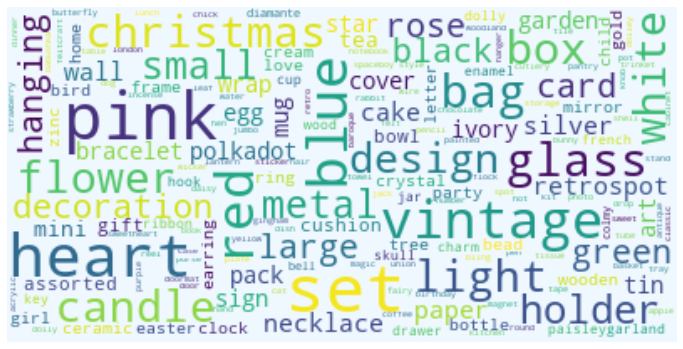

In [287]:
words=[]
for sentence in m:
  tokenizer = RegexpTokenizer('\w+')
  new_words=tokenizer.tokenize(sentence)
  for word in new_words:
    words.append(word) 
words

d = Counter(words)
wordcloud = WordCloud(
                background_color ='aliceblue',collocations=False,max_font_size=40).generate(" ".join([(k + ' ') * v for k,v in d.items()]))
plt.figure(figsize = (12, 12), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


Using TF-IDF Vectorization to convert words to vectors

In [288]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

tfidf_vectorizer = TfidfVectorizer() # Intialise the model 
values = tfidf_vectorizer.fit_transform(m)

# Show the Model as a pandas DataFrame
#tfidf=values.toarray()
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf=pd.DataFrame(values.toarray(), columns = feature_names)
print(tfidf.shape)
tfidf

(3871, 1686)


,abc,abstract,acapulco,account,acrylic,address,ade,adult,advent,afghan,...,woven,wrap,wrapping,wreath,wrecking,writing,xma,yellow,yuletide,zinc
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.502991
3867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.385784
3868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.429804
3869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.431829


7    2540
0     289
3     246
2     202
5     173
6     159
1     153
4     109
dtype: int64


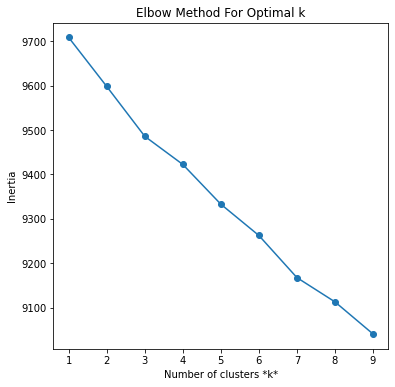

In [289]:
scaler = MinMaxScaler()
X_std = scaler.fit_transform(tfidf)

modelkmeans = KMeans()
modelkmeans.fit(X_std)

cluster = modelkmeans.predict(X_std)
print(pd.Series(cluster).value_counts())

inertias = []  # storer inertia for all values of k 
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_std)
    inertias.append(km.inertia_)

# Plot sse against k

plt.figure(figsize=(6, 6))
plt.plot(list_k, inertias, '-o')
plt.title('Elbow Method For Optimal k')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Inertia');

In this method, Cluster contains disproportionate number of data in each clusters and from the elbow plot nothing can be inferred.

Hence, a new method where every tfidf score is added row wise and clustering is made against UnitPrice of those row products

In [290]:
tfidf['Total']=tfidf.sum(axis=1)
tfidf

,abc,abstract,acapulco,account,acrylic,address,ade,adult,advent,afghan,...,wrap,wrapping,wreath,wrecking,writing,xma,yellow,yuletide,zinc,Total
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.982871
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.990794
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.721626
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.977672
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.974324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.502991,2.228765
3867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.385784,2.222139
3868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.429804,1.955487
3869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.431829,1.989583


In [291]:
data = [tfidf["Total"], df_P['UnitPrice']]

headers = ["TfidfScore", "UnitPrice"]

tfidf1 = pd.concat(data, axis=1, keys=headers)
tfidf1

,TfidfScore,UnitPrice
0,1.982871,2.324359
1,1.990794,1.248073
2,1.721626,1.243841
3,1.977672,4.138571
4,1.974324,4.150000
...,...,...
3866,2.228765,0.836975
3867,2.222139,16.950000
3868,1.955487,0.872344
3869,1.989583,7.175000


In [292]:
tfidf1.describe()

,TfidfScore,UnitPrice
count,3871.000000,3871.000000
mean,1.950161,3.541847
std,0.203900,12.404444
min,1.000000,0.043478
25%,1.731856,1.004318
50%,1.963982,1.950000
75%,2.138684,3.842084
max,2.439058,649.500000


2    1896
0     999
1     976
dtype: int64


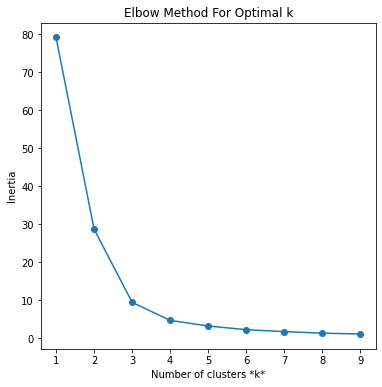

In [293]:
scaler = MinMaxScaler()
X_std1 = scaler.fit_transform(tfidf1)

modelkmeans = KMeans(n_clusters=3,n_init=10,max_iter=500)
modelkmeans.fit(X_std1)

cluster = modelkmeans.predict(X_std1)
print(pd.Series(cluster).value_counts())

inertias = []  # storer inertia for all values of k 
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_std1)
    inertias.append(km.inertia_)

# Plot sse against k

plt.figure(figsize=(6, 6))
plt.plot(list_k, inertias, '-o')
plt.title('Elbow Method For Optimal k')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Inertia');

In [294]:
kmeans = KMeans(n_clusters= 3)
label = kmeans.fit_predict(X_std1)
 
print(set(label))

{0, 1, 2}


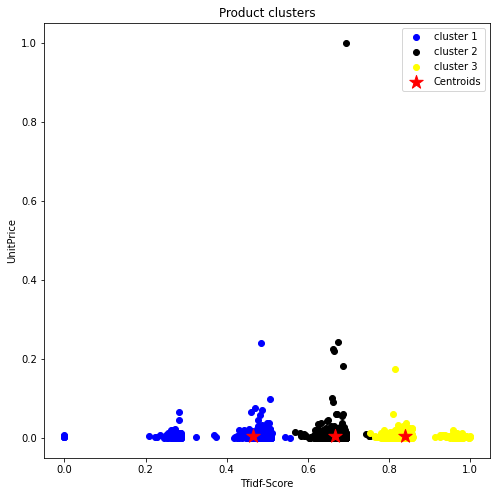

In [295]:
filtered_label0 = X_std1[label == 0]
filtered_label1 = X_std1[label == 1]
filtered_label2 = X_std1[label == 2]

fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1] , color = 'blue',label='cluster 1')
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1] , color = 'black',label='cluster 2')
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1] , color = 'yellow',label='cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],marker='*', s=200, c='red', label = 'Centroids')
plt.title('Product clusters')
plt.xlabel('Tfidf-Score')
plt.ylabel('UnitPrice')
plt.legend()
plt.show()


##Final Dataframes for grouping customers

In [296]:
df2 = pd.DataFrame(kmeans.labels_)
print(df2.shape)
df2.head(3)

(3871, 1)


,0
0,1
1,1
2,0


In [297]:
df3=df_P.join(df2)
df3.rename(columns={0:'Product Cluster'},inplace=True)
df3.head(3)

,Description,UnitPrice,Product Cluster
0,4 PURPLE FLOCK DINNER CANDLES,2.324359,1
1,50'S CHRISTMAS GIFT BAG LARGE,1.248073,1
2,DOLLY GIRL BEAKER,1.243841,0


In [298]:
df4 = pd.merge(df, df3, how='left', on='Description')
df4.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice_x,CustomerID,Country,Amount,UnitPrice_y,Product Cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2.893107,2
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,3.716320,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,3.816311,2


In [299]:
df5 = pd.get_dummies(df4,columns=["Product Cluster"])
df5.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice_x,CustomerID,Country,Amount,UnitPrice_y,Product Cluster_0,Product Cluster_1,Product Cluster_2
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2.893107,0,0,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,3.716320,1,0,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,3.816311,0,0,1


In [300]:
df5.CustomerID = df5.CustomerID.astype('object')
df5

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice_x,CustomerID,Country,Amount,UnitPrice_y,Product Cluster_0,Product Cluster_1,Product Cluster_2
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2.893107,0,0,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,3.716320,1,0,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,3.816311,0,0,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,4.001595,0,0,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,4.054756,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
396332,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,0.847478,1,0,0
396333,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2.126336,0,1,0
396334,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,4.142754,0,1,0
396335,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,4.164861,0,1,0


Groupby only unique values in each product cluster instead of grouping all values

In [301]:
df6=df5.groupby(['CustomerID','Description'])['Product Cluster_0','Product Cluster_1','Product Cluster_2'].sum()
df6.head()

Product Cluster_0  \
CustomerID Description                                         
12346.0    MEDIUM CERAMIC TOP STORAGE JAR                  0   
12347.0    3D DOG PICTURE PLAYING CARDS                    0   
           3D SHEET OF CAT STICKERS                        1   
           3D SHEET OF DOG STICKERS                        1   
           60 TEATIME FAIRY CAKE CASES                     0   

                                           Product Cluster_1  \
CustomerID Description                                         
12346.0    MEDIUM CERAMIC TOP STORAGE JAR                  0   
12347.0    3D DOG PICTURE PLAYING CARDS                    5   
           3D SHEET OF CAT STICKERS                        0   
           3D SHEET OF DOG STICKERS                        0   
           60 TEATIME FAIRY CAKE CASES                     3   

                                           Product Cluster_2  
CustomerID Description                                        
12346.0    MEDIUM CERAMIC TOP STORAGE JAR                  1  
12347.0    3D DOG PICTURE PLAYING CARDS                    0  
           3D SHEET OF CAT STICKERS                        0  
           3D SHEET OF DOG STICKERS                        0  
           60 TEATIME FAIRY CAKE CASES                     0

In [302]:
df6['Product Cluster_0']=df6['Product Cluster_0'].clip(0,1)
df6['Product Cluster_1']=df6['Product Cluster_1'].clip(0,1)
df6['Product Cluster_2']=df6['Product Cluster_2'].clip(0,1)

In [303]:
df7=df6.groupby('CustomerID')['Product Cluster_0','Product Cluster_1','Product Cluster_2'].sum()
df7

,Product Cluster_0,Product Cluster_1,Product Cluster_2
CustomerID,,,
12346.0,0.0,0.0,1.0
12347.0,24.0,51.0,28.0
12348.0,7.0,9.0,5.0
12349.0,19.0,26.0,27.0
12350.0,7.0,6.0,3.0
...,...,...,...
18280.0,2.0,6.0,2.0
18281.0,3.0,3.0,1.0
18282.0,2.0,6.0,4.0


In [304]:
df7.reset_index(inplace=True, level = ['CustomerID'])
df7

,CustomerID,Product Cluster_0,Product Cluster_1,Product Cluster_2
0,12346.0,0.0,0.0,1.0
1,12347.0,24.0,51.0,28.0
2,12348.0,7.0,9.0,5.0
3,12349.0,19.0,26.0,27.0
4,12350.0,7.0,6.0,3.0
...,...,...,...,...
4329,18280.0,2.0,6.0,2.0
4330,18281.0,3.0,3.0,1.0
4331,18282.0,2.0,6.0,4.0
4332,18283.0,77.0,130.0,64.0


In [305]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396337 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    396337 non-null  object        
 1   StockCode    396337 non-null  object        
 2   Description  396337 non-null  object        
 3   Quantity     396337 non-null  int64         
 4   InvoiceDate  396337 non-null  datetime64[ns]
 5   UnitPrice    396337 non-null  float64       
 6   CustomerID   396337 non-null  object        
 7   Country      396337 non-null  object        
 8   Amount       396337 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 30.2+ MB


In [306]:
df_CustomerID1=df.groupby('CustomerID')['InvoiceNo','InvoiceDate','Description'].agg(lambda x: x.nunique()).reset_index()
df_CustomerID1

,CustomerID,InvoiceNo,InvoiceDate,Description
0,12346.0,1,1,1
1,12347.0,7,7,103
2,12348.0,4,4,21
3,12349.0,1,1,72
4,12350.0,1,1,16
...,...,...,...,...
4329,18280.0,1,1,10
4330,18281.0,1,1,7
4331,18282.0,2,2,12
4332,18283.0,16,16,271


In [307]:
df_Amount=df.groupby('CustomerID')['Amount'].agg(sum).reset_index()
df_Amount

,CustomerID,Amount
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1437.24
3,12349.0,1457.55
4,12350.0,294.40
...,...,...
4329,18280.0,180.60
4330,18281.0,80.82
4331,18282.0,178.05
4332,18283.0,2088.93


In [308]:
df_Country=df.groupby('CustomerID')['Country'].agg(pd.Series.mode).reset_index()
df_Country

,CustomerID,Country
0,12346.0,United Kingdom
1,12347.0,Iceland
2,12348.0,Finland
3,12349.0,Italy
4,12350.0,Norway
...,...,...
4329,18280.0,United Kingdom
4330,18281.0,United Kingdom
4331,18282.0,United Kingdom
4332,18283.0,United Kingdom


In [309]:
dfs = [df_CustomerID1,df_Amount, df_Country,df7]

#merge all DataFrames into one
final_df = reduce(lambda  left,right: pd.merge(left,right,on=['CustomerID'],
                                            how='inner'), dfs)

#view merged DataFrame
print(final_df)

      CustomerID  InvoiceNo  InvoiceDate  Description    Amount  \
0        12346.0          1            1            1  77183.60   
1        12347.0          7            7          103   4310.00   
2        12348.0          4            4           21   1437.24   
3        12349.0          1            1           72   1457.55   
4        12350.0          1            1           16    294.40   
...          ...        ...          ...          ...       ...   
4329     18280.0          1            1           10    180.60   
4330     18281.0          1            1            7     80.82   
4331     18282.0          2            2           12    178.05   
4332     18283.0         16           16          271   2088.93   
4333     18287.0          3            3           59   1837.28   

             Country  Product Cluster_0  Product Cluster_1  Product Cluster_2  
0     United Kingdom                0.0                0.0                1.0  
1            Iceland               

A new dataframe is created from the existing dataframe(by groupby and aggregate)



*   CustomerID contains the unique customers
*   InvoiceNo shows how many times a single customer visited the website during the time period
*   InvoiceDate shows how many different days a single customer visited the website during the time period
*   Description shows how many differnt product a single customer bought
*   Amount shows amount spent by each customer
*   Country shows their country of origin
*   Product_Cluster columns shows how many different products from each cluster is bought by each customer










In [310]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4334 entries, 0 to 4333
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         4334 non-null   float64
 1   InvoiceNo          4334 non-null   int64  
 2   InvoiceDate        4334 non-null   int64  
 3   Description        4334 non-null   int64  
 4   Amount             4334 non-null   float64
 5   Country            4334 non-null   object 
 6   Product Cluster_0  4334 non-null   float64
 7   Product Cluster_1  4334 non-null   float64
 8   Product Cluster_2  4334 non-null   float64
dtypes: float64(5), int64(3), object(1)
memory usage: 338.6+ KB


In [311]:
final_df['Product Cluster_0'] = final_df['Product Cluster_0'].astype('int64')
final_df['Product Cluster_1'] = final_df['Product Cluster_1'].astype('int64')
final_df['Product Cluster_2'] = final_df['Product Cluster_2'].astype('int64')

In [312]:
final_df.rename(columns = {'InvoiceNo':'no_of_invoice', 'InvoiceDate':'no_of_dates','Description':'no_of_products'}, inplace = True)

In [313]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4334 entries, 0 to 4333
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         4334 non-null   float64
 1   no_of_invoice      4334 non-null   int64  
 2   no_of_dates        4334 non-null   int64  
 3   no_of_products     4334 non-null   int64  
 4   Amount             4334 non-null   float64
 5   Country            4334 non-null   object 
 6   Product Cluster_0  4334 non-null   int64  
 7   Product Cluster_1  4334 non-null   int64  
 8   Product Cluster_2  4334 non-null   int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 338.6+ KB


In [314]:
final_df.describe()

,CustomerID,no_of_invoice,no_of_dates,no_of_products,Amount,Product Cluster_0,Product Cluster_1,Product Cluster_2
count,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000
mean,15299.251731,4.245962,4.224735,61.770651,2021.473616,17.058837,30.223812,14.488002
std,1721.994109,7.634989,7.571661,86.164852,8907.501378,24.190375,42.358854,20.942245
min,12346.000000,1.000000,1.000000,1.000000,3.750000,0.000000,0.000000,0.000000
25%,13812.250000,1.000000,1.000000,16.000000,305.560000,4.000000,7.000000,3.000000
50%,15297.500000,2.000000,2.000000,35.000000,668.125000,10.000000,17.000000,8.000000
75%,16778.750000,5.000000,5.000000,78.000000,1631.622500,22.000000,38.000000,18.000000
max,18287.000000,206.000000,207.000000,1814.000000,279138.020000,498.000000,889.000000,429.000000


no_of_invoice and no_of_dates looks identical. Hence, one column can be deleted.

In [315]:
final_df.sum(axis=0)

CustomerID                                                  66306957.0
no_of_invoice                                                    18402
no_of_dates                                                      18310
no_of_products                                                  267714
Amount                                                      8761066.65
Country              United KingdomIcelandFinlandItalyNorwayNorwayB...
Product Cluster_0                                                73933
Product Cluster_1                                               130990
Product Cluster_2                                                62791
dtype: object

In [316]:
130990+73933+62791

267714

Sum of all the product clusters in each row is equal to no_of products.Hence, no_of_products column can be deleted 

In [317]:
final_df.Country.value_counts()

United Kingdom          3916
Germany                   94
France                    87
Spain                     29
Belgium                   24
Switzerland               20
Portugal                  19
Italy                     14
Finland                   12
Norway                    10
Netherlands                9
Austria                    9
Channel Islands            9
Australia                  9
Sweden                     8
Japan                      8
Denmark                    8
Cyprus                     6
Poland                     6
USA                        4
Canada                     4
Greece                     4
Unspecified                4
Israel                     3
EIRE                       3
United Arab Emirates       2
Bahrain                    2
Malta                      2
Saudi Arabia               1
Singapore                  1
Iceland                    1
RSA                        1
Lebanon                    1
Brazil                     1
Czech Republic

Country column data is imbalanced since majority of customers belong to 'United Kingdom' . Hence, country column can be deleted

---



In [318]:
final_df1 = final_df[['no_of_invoice','Amount',	'Product Cluster_0',	'Product Cluster_1'	,'Product Cluster_2']]
final_df1

,no_of_invoice,Amount,Product Cluster_0,Product Cluster_1,Product Cluster_2
0,1,77183.60,0,0,1
1,7,4310.00,24,51,28
2,4,1437.24,7,9,5
3,1,1457.55,19,26,27
4,1,294.40,7,6,3
...,...,...,...,...,...
4329,1,180.60,2,6,2
4330,1,80.82,3,3,1
4331,2,178.05,2,6,4
4332,16,2088.93,77,130,64


In [319]:
final_df1.describe()

,no_of_invoice,Amount,Product Cluster_0,Product Cluster_1,Product Cluster_2
count,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000
mean,4.245962,2021.473616,17.058837,30.223812,14.488002
std,7.634989,8907.501378,24.190375,42.358854,20.942245
min,1.000000,3.750000,0.000000,0.000000,0.000000
25%,1.000000,305.560000,4.000000,7.000000,3.000000
50%,2.000000,668.125000,10.000000,17.000000,8.000000
75%,5.000000,1631.622500,22.000000,38.000000,18.000000
max,206.000000,279138.020000,498.000000,889.000000,429.000000


## Modelling

1    2690
0    1096
3     369
4     107
7      57
2       7
5       5
6       3
dtype: int64


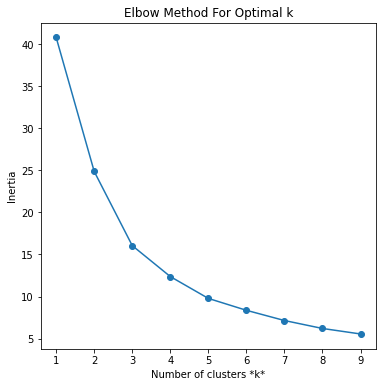

In [320]:
scaler = MinMaxScaler()
X_std_final = scaler.fit_transform(final_df1)

modelkmeans = KMeans()
modelkmeans.fit(X_std_final)

cluster = modelkmeans.predict(X_std_final)
print(pd.Series(cluster).value_counts())

inertias = []  # storer inertia for all values of k 
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_std_final)
    inertias.append(km.inertia_)

# Plot sse against k

plt.figure(figsize=(6, 6))
plt.plot(list_k, inertias, '-o')
plt.title('Elbow Method For Optimal k')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Inertia');

In [321]:
kmeans = KMeans(n_clusters= 3)
label = kmeans.fit_predict(X_std_final)
 
cluster = kmeans.predict(X_std_final)
print(pd.Series(cluster).value_counts())

0    3728
2     596
1      10
dtype: int64


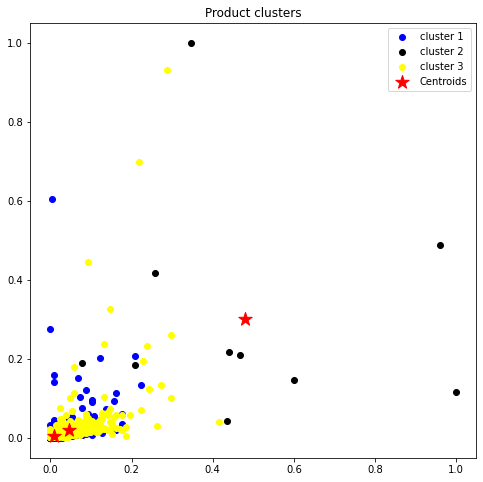

In [322]:
filtered_label0 = X_std_final[label == 0]
filtered_label1 = X_std_final[label == 1]
filtered_label2 = X_std_final[label == 2]

fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1] , color = 'blue',label='cluster 1')
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1] , color = 'black',label='cluster 2')
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1] , color = 'yellow',label='cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],marker='*', s=200, c='red', label = 'Centroids')
plt.title('Product clusters')
plt.legend()
plt.show()


# Inference

In [323]:
final_df1.corr()

,no_of_invoice,Amount,Product Cluster_0,Product Cluster_1,Product Cluster_2
no_of_invoice,1.000000,0.548506,0.677797,0.686274,0.687883
Amount,0.548506,1.000000,0.375156,0.379110,0.377464
Product Cluster_0,0.677797,0.375156,1.000000,0.957865,0.928175
Product Cluster_1,0.686274,0.379110,0.957865,1.000000,0.959838
Product Cluster_2,0.687883,0.377464,0.928175,0.959838,1.000000


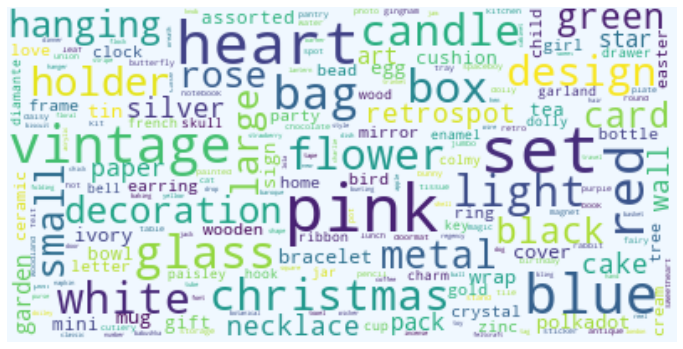

In [324]:
wordcloud = WordCloud(
                background_color ='aliceblue',collocations=False,max_font_size=40).generate(" ".join([(k + ' ') * v for k,v in d.items()]))
plt.figure(figsize = (12, 12), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [325]:
final_df1['Amount'].describe()

count      4334.000000
mean       2021.473616
std        8907.501378
min           3.750000
25%         305.560000
50%         668.125000
75%        1631.622500
max      279138.020000
Name: Amount, dtype: float64

In [326]:

Q1 = final_df1.Amount.quantile(0.25)
Q3 = final_df1.Amount.quantile(0.75)
IQR = Q3-Q1
final_df2 = final_df1[~((final_df1.Amount<(Q1-1.5*IQR)) | (final_df1.Amount>(Q3+1.5*IQR)))]
final_df2.shape

(3909, 5)

In [327]:
((4334-3909)/4334)*100

9.806183664051686



*   From the correlation matrix, we can see that all three product clusters have strong correlation between them.
*   From the WordCloud , we can see that adjective like set, pack, small ,large and different colours(green, blue,white...) are the words mostly present in the description of the product.
*   We can also that Amount column of the dataframe has nearly 10% outliers

These may be the reason for grouping majority customers in one group.


